<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Breast Cancer Dataset: Classification
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b> 
    Paola Maragno  <br>
    <a href="mailto:paola.maragno@mail.polimi.it">paola.maragno@mail.polimi.it</a><br>
    </div>
    </td>
</tr>
</table>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
np.random.seed(0)

# Data loading and pre-processing

In [2]:
# Read the data and create a pandas DataFrame

pd_data = pd.read_csv("breast-cancer-wisconsin.data",names = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape',
                                                             'Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli',
                                                             'Mitoses','Class'])

# Visualize the first rows of the DataFrame
pd_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
# Inspect the dimension of the DataFrame
pd_data.shape

(699, 11)

In [4]:
# Inspect the data type of the different columns of the DataFrame
pd_data.dtypes

Sample code number              int64
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [5]:
# Bare Nuclei variable is of type object even if it is expected to be numeric: this suggests the presence of missing 
# values for this variable

np.unique(pd_data['Bare Nuclei'].values)

# as expected there are some missing values identified by '?'

array(['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?'],
      dtype=object)

In [6]:
# Count how many missing values there are
(pd_data['Bare Nuclei']== '?').sum()

# Since they are 16 among 699 overall observations we can remove them

16

In [7]:
# Remove the missing values
pd_data = pd_data.replace('?',np.nan).dropna()

pd_data.shape

(683, 11)

In [8]:
# Cast Bare Nuclei variable in integer type
pd_data['Bare Nuclei'] = pd_data['Bare Nuclei'].astype('int64')

In [9]:
# Control which values are present in variable Class
print(np.unique(pd_data['Class']))
# 2 is used for benign class, 4 for malignant

# Replace 2 with 0 and 4 with 1
pd_data['Class'] = pd_data['Class'].replace({2: 0, 4:1})

[2 4]


In [10]:
# Since the identification code of each sample is not a variable that can be used to build a classification model we 
# can drop it
pd_data = pd_data.drop(['Sample code number'],axis=1)

In [11]:
# Inspect the proportion of observations of each class
pd_data['Class'].value_counts()/pd_data.shape[0]*100

0    65.007321
1    34.992679
Name: Class, dtype: float64

Since the dataset is quite unbalanced, with 65% of observations of class 0 and 35% of class 1, when I will perform the splitting of the dataset into the train and test set, as well as the splitting of the train set in k-folds during cross validation, I have to pay attention that this proportion between the data of the two classes is always respected.

# Data visualization

## Inspect variable distribution through histogram

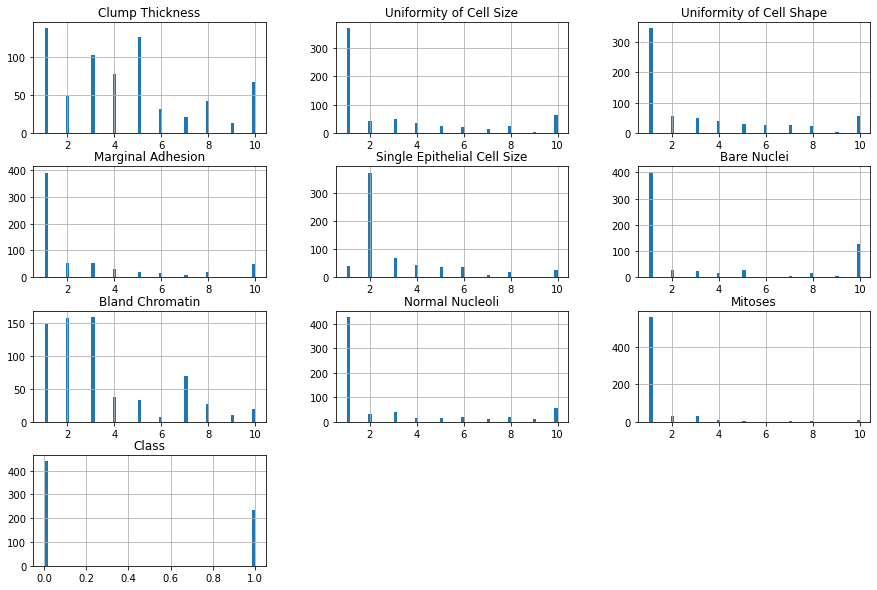

In [12]:
pd_data.hist(bins=50, figsize=(15,10), ec='w')
plt.show()

We can see that, except for Clump Thickness and Bland Chromatin variables, all the observations have very frequently value 1 for more or less all the variables.
Bland Chromatin values are more concentrated around 1-3, while Clump Thickness is the only variable that shows also higher values with a more significative frequency.

## Scatterplot

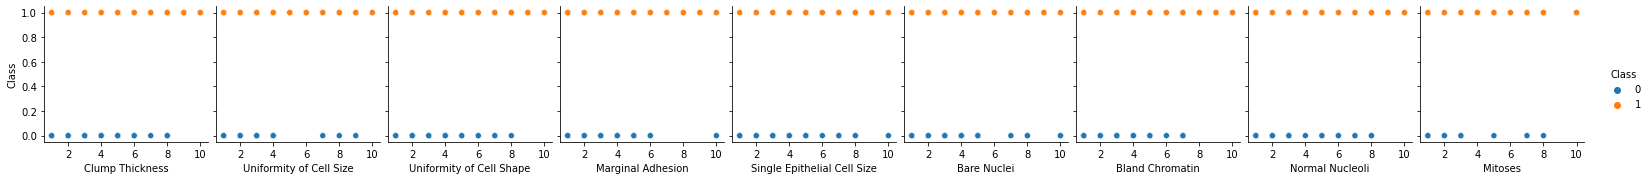

In [13]:
sns.pairplot(pd_data, x_vars = pd_data.columns.to_list().remove('Class'), y_vars=['Class'], hue = 'Class', height=2.5)

From the scatterplot is clearly visible that malignant samples show all the possible values, between 1 and 10, of all the variables; instead benignant samples in the majority of cases have lower values of the features. 
Since this behaviour is present actually for all the variables, I expect all of them to be useful for the classification task.

## Correlation matrix

<AxesSubplot:>

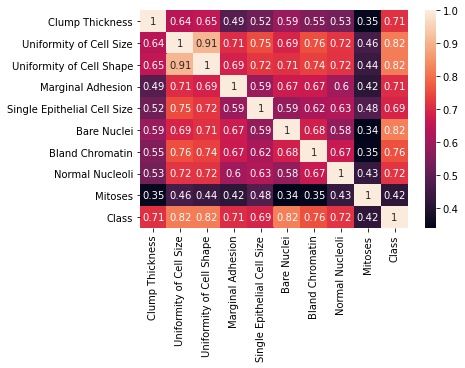

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap((pd_data).corr(), annot = True)

The target variable seems to be highly correlated with Uniformity of cell size and shape, Bare Nuclei and Bland Chromatin. Anyway it shows a high correlation with all the features since the lowest correlation value that is reported is 0.4 and only Mitoses has a so low correlation with the target variable, while all the other features show a correlation of at least 0.69 with the Class label.

Furthermore I can observe that the different features tend to be highly correlated between each other: this is expected since these variables represent biological characteristics all regarding the breast cells and the microenviroment in which they are. 

# Classifier evaluation strategy

In the next session I will train different classifiers to then evaluate which is the best one in predicting the label of my data.
To evaluate them and to look for the parameters that some of the classification models require I use as evaluation metric the sensitivity.

The sensitivity or recall is the true positive rate, so the proportion of malignant observations that are actually classified as so. This is the ratio between the correctly positive predictions and the total number of positive observations in the dataset (even if some of them may have been wrongly classified as negative by the model).

I choose this metric since in the medical field it is important to consider that the false positive rate and false negative rate have different weight: it is better to have a high false positive rate, diagnosing a person as ill even if he isn't, than having a high false negative rate with the risk of evaluating a person as healthy when he is actually ill. Since the sensitivity is the proportion of true positive classifications among the total number of observations that are trully positive (even if maybe they have been classified as negative), I used this evaluation metric as the main one to select the best model: the higher is the sensitivity the lowest is the false negative rate.

# Classification with Logistic Regression

Logistic Regression is a linear classifier in the sense that the log odds (logit) is a linear combination of the covariates X

In [15]:
y = pd_data['Class'].to_numpy()
X = pd_data.drop(['Class'],axis=1)

# Split the data into training and test. Since the dataset is made of a lot of observations we can use 30% of them 
# as test set
split_seed = 42
split_test_size = 0.3

# We have seen that the dataset is unbalanced so I pass as stratify parameter of the train_test_split function
# the array of values of the Class variable of the dataset so that the splitting is performed randomly but ensuring 
# that the proportion of observations of the two classes in the train and the test set remains the same as in the 
# total dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed,
                                                    stratify = y)

In [16]:
# Build and train the Logistic Regression model: we want to model the probability of being a malignant sample
# given the values of all the covariates. 
# The Logistic function returns a probability, and so a value between 0 and 1.

from sklearn.linear_model import LogisticRegression    

# Use a particular solver of the maximum likelihood function
model = LogisticRegression(solver="newton-cg", penalty='none')  
model.fit(X_train, y_train)  

LogisticRegression(penalty='none', solver='newton-cg')

In [17]:
from sklearn.metrics import recall_score

print("Train sensitivity:", recall_score(y_train, model.predict(X_train)))
print("Test sensitivity:", recall_score(y_test, model.predict(X_test)))

Train sensitivity: 0.9640718562874252
Test sensitivity: 0.9444444444444444


The sensitivity of the Logistic regressor on never seen data is quite high, of the 94.4%.
Anyway, since we don't know if the observations of the two different classes are linearly separable, and so if Logistic Regression is the best way to classify our data, it makes no sense to find the best features selecting them through the evaluation of the performance of a classifier that is based on an assumption that our data may not satisfy.

## Coefficients interpretation

Differently from linear regression the parameters don't directly act on the model output (that in this case is the probability) but on the log-odds: in fact the meaning of the coefficient of a variable is that the exponential of the coefficient is the increase of the odds ratio as consequence of a unitary increase of the variable, when all the other features remain constant.

In [18]:
beta_bare_nuclei = model.coef_[0,0]
print("The unitary inrease of Bare Nulcei value increases the log odds by:", beta_bare_nuclei)
print("Which means increasing the odds by:", np.exp(beta_bare_nuclei))

The unitary inrease of Bare Nulcei value increases the log odds by: 0.5197621491610662
Which means increasing the odds by: 1.681627625586217


The interpretation is that an unitary increase of the number of Bare Nuclei in the patient increses the risk of being malignant of the 68%.

# Model evaluation

The confusion matrix reports how many observations, both negative and positive, have been correctly classified by the model.
The matrix also contains the numbers of wrongly predicted observations: the number of false negatives and false positives.

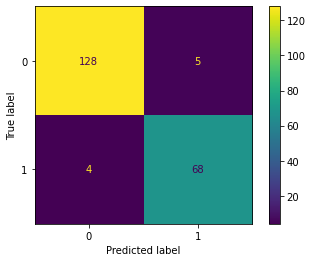

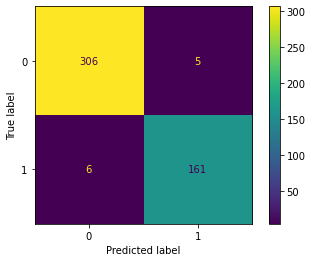

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = LogisticRegression(solver="newton-cg", penalty='none')  
model.fit(X_train, y_train)  

cm = confusion_matrix(y_test,model.predict(X_test))
cm2 = confusion_matrix(y_train,model.predict(X_train))

# Plot test confution matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
# Plot train confution matrix
disp2 = ConfusionMatrixDisplay(cm2)
disp2.plot()
plt.show()

In [20]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

def sensitivity(cm):
    TP = cm[1,1]
    T = cm[1,:].sum()
    return TP / T

def specificity(cm):
    TN = cm[0,0]
    N = cm[0,:].sum()
    return TN / N

def precision(cm):
    TP = cm[1,1]
    TPFP = cm[:,1].sum()
    return TP / TPFP

def f1(cm):
    p = precision(cm)
    r = sensitivity(cm)
    return (2 * p * r) / (p + r)

print("Test accuracy ", accuracy(y_test, model.predict(X_test)))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm))

Test accuracy  0.9560975609756097
Specificity  0.9624060150375939
Precision  0.9315068493150684
F1-score 0.9379310344827586


The accuracy is a measure of how many times on average the model is able to classify the samples in the right way.

The specificity is the true negative rate, so the proportion of benignant observations that are actually classified as so. This is the ratio between the correctly negative predictions and the total number of negative observations in the dataset (even if some of them may have been wrongly classified as positive by the model).

The precision is the number of true positive prediction among all those have being predicted as positive (even if maybe they are negative).

F1 score is the most accurate and precise evaluation metric.

All the metrics are computed on the test set.

Another important evaluation can be done using the ROC curve in which the false positive rate is plotted on the x-axis while the true positive rate on the y-axis: the best model is the one that maximises the TPR and minimizes the FPR and so the closer to 1 is the area under the ROC curve the better the model is.

AUC train: 0.9979205575986292
AUC test: 0.9909147869674186


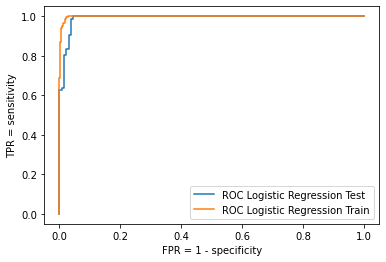

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()
    
plot_roc(model.predict_proba, X_test, y_test, "Logistic Regression Test")
plot_roc(model.predict_proba, X_train, y_train, "Logistic Regression Train")

print(f'AUC train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}')
print(f'AUC test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}')

The ROC curve is built changing the threshold value, used to assign an observation to a class depending on the probability of belonging to Class=1 returned by the Logistic model, and counting the corresponding true positive rate and false positive rate. When the threshold is low, everything is classified as belonging to class 1, so you have a high false positive rate and a high true positive rate (this is the point in the right top corner), increasing the threshold the false positive rate decreases as well as the true positive one until you reach the bottom left corner. The best balance is in the left top corner with high true positive rate and low false positive rate.

# Classification with Linear Disciminant Analysis 

As Logistic Regression, also LDA models the posterior probabilities as a linear function of the covariates. However, the relation is found through the Bayes Theorem instead of the Logistic function.

In this case we know the a priori probability of being malignant and we work with a priori probability and the distribution of features to build a model that classifies the samples.

The assumptions of LDA are that the classes must have a common covariance matrix and that the distribution of features in each class must be multivariate Gaussian.
Even LDA is a linear classifier meaning that the log odds is linear with respect to the covariates X.

In [22]:
# As before, first I build the LDA model, then I fit it on the train set and evaluate the fitted model on the train 
# and test sets

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model = LDA(store_covariance=True)
model = model.fit(X_train, y_train)

print("Train sensitivity:", recall_score(y_train, model.predict(X_train)))
print("Test sensitivity:", recall_score(y_test, model.predict(X_test)))

Train sensitivity: 0.9341317365269461
Test sensitivity: 0.8888888888888888


The sensitivity of LDA is quite low, of 88.9%, so I try to apply the polynomial trasformation to the data to see if in this way the performance of LDA improves.

## LDA with polynomial features

We can convert features into polynomial ones and then fit the LDA model in the new feature space: in this space the decision boundary is linear, but it looks polynomial if projected back into the original input space. 

We can use GridSearch plus cross validation to find the best degree.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(recall_score))
cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('lda',
                                        LinearDiscriminantAnalysis(store_covariance=True))]),
             param_grid={'poly__degree': range(1, 6)},
             scoring=make_scorer(recall_score))

In [24]:
cv.best_params_
cv.best_score_
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002712,0.000318,0.001195,0.000102,1,{'poly__degree': 1},0.9375,0.882353,0.823529,1.000000,0.882353,0.941176,0.941176,0.941176,1.0000,0.8750,0.922426,0.053441,2
1,0.005673,0.001704,0.001355,0.000284,2,{'poly__degree': 2},0.9375,0.882353,0.882353,1.000000,0.941176,0.941176,0.882353,0.941176,1.0000,0.8750,0.928309,0.044764,1
2,0.021224,0.002225,0.001716,0.000448,3,{'poly__degree': 3},0.6875,0.411765,0.470588,0.647059,0.588235,0.705882,0.764706,0.529412,0.6875,0.5625,0.605515,0.106897,4
3,0.092166,0.024903,0.002127,0.000790,4,{'poly__degree': 4},0.6875,0.647059,0.705882,0.588235,0.588235,0.529412,0.647059,0.764706,0.6875,0.6250,0.647059,0.064668,3
4,0.231555,0.028037,0.001873,0.000108,5,{'poly__degree': 5},0.2500,0.588235,0.764706,0.529412,0.588235,0.529412,0.764706,0.647059,0.6250,0.6250,0.591176,0.137726,5


  (best 2) CV sensitivity: 0.9283088235294118
  (best 2) Test sensitivity: 0.9305555555555556


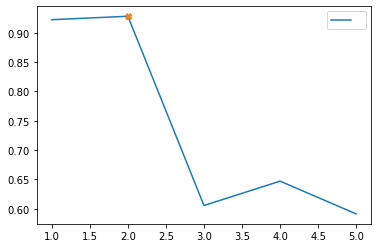

In [25]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx],marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV sensitivity:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test sensitivity:", recall_score(y_test, cv.best_estimator_.predict(X_test)))
    
show_results(cv, X_test, 'param_poly__degree')

The best LDA model according to the sensitivity score is the one with degree 2: this suggests that the observations of the two classes are not linearly separable and for this reason a polynomial classifier performs better in detecting the malignant samples.

## Model evaluation

Sensitivity 0.9305555555555556
Specificity 0.9624060150375939
Test accuracy: 0.9512195121951219
Precision  0.9305555555555556
F1-score 0.9305555555555556
AUC train: 0.9988640083177697
AUC test: 0.9886173767752715



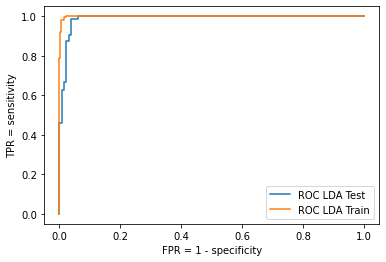

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly = poly.fit(X_train)

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
 
model = LDA(store_covariance=True)
model = model.fit(X_train_poly, y_train)
        
cm = confusion_matrix(y_test, model.predict(X_test_poly))
print("Sensitivity", sensitivity(cm))
print("Specificity", specificity(cm))
print("Test accuracy:", accuracy(y_test, model.predict(X_test_poly)))
print("Precision ", precision(cm))
print("F1-score", f1(cm))
print(f'AUC train: {roc_auc_score(y_train, model.predict_proba(X_train_poly)[:, 1])}')
print(f'AUC test: {roc_auc_score(y_test, model.predict_proba(X_test_poly)[:, 1])}\n')

plot_roc(model.predict_proba, X_test_poly, y_test, "LDA Test")
plot_roc(model.predict_proba, X_train_poly, y_train, "LDA Train")

# Classification with Quadratic Disciminant Analysis

QDA derives from LDA model without the assumption that the density functions must have the same covariance matrix.

Train accuracy: 0.9581589958158996
Test accuracy: 0.9560975609756097
Sensitivity 0.9583333333333334
Specificity 0.9548872180451128
Precision  0.92
F1-score 0.9387755102040817
AUC train: 0.9948399021891907
AUC test: 0.9852756892230576


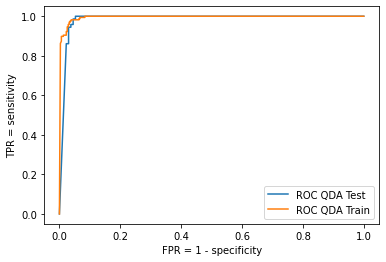

In [27]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model = QDA(store_covariance = True)
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))

print("Sensitivity", sensitivity(cm))
print("Specificity", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm))
print(f'AUC train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}')
print(f'AUC test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}')

plot_roc(model.predict_proba, X_test, y_test, "QDA Test")
plot_roc(model.predict_proba, X_train, y_train, "QDA Train")

We can see that QDA performs better than the previous trained linear classifiers, and also the polynomial LDA, not only considering the sensitivity but also the test accuracy and the f1 score.

# Classification with K-Nearest Neighbors

KNN is a non-parametric model: each time it has to predict the class of a new unseen observation it identifies its k closest training points and predicts as class of the new point the most frequent class among the selected neighbors.
This is not a robust algorithm.

## KNN Hyperparameter Selection

We use Grid search with cross validation to select the best k parameter for the dataset: we expect that a large value of k results in a smoother boundary, since the classification of the new observation is done considering the class of a lot of neighbors around it, while a small value of k leads to a more complex model, since in this case the decision boundary is not linear at all considering that only the very close k neighbors are taken in evaluation.

Since KNN relies on sample distances to perform prediction, having normalized features on the same range allows samples to be compared more reliably. 
In fact, if one variable is on a higher scale than another one, the first variable will be valued more by the algorithm even if maybe it is actually not so important for the classification. This is why it may be useful to scale the variables.

We can perform two different types of normalization: range normalization - which makes all the features have values between [0,1] - and z-score normalization - that makes features have 0 mean and unitary variance.

I performed GridSearchCV not only to select the best k parameter but also to understand if the KNN model performs better on normalized or unnormalized features.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 20)}
cv = GridSearchCV(model, params, refit=True, cv = 10, 
                  scoring = make_scorer(recall_score))
cv.fit(X_train, y_train)

params = {'knn__n_neighbors': range(1, 20)}
model_std = Pipeline([
    ('norm', StandardScaler()),
    ('knn', KNeighborsClassifier())])
cv_std = GridSearchCV(model_std, params, refit=True, cv=10,
                     scoring=make_scorer(recall_score))
cv_std.fit(X_train, y_train)

model_minmax = Pipeline([
    ('norm', MinMaxScaler()),
    ('knn', KNeighborsClassifier())])
cv_minmax = GridSearchCV(model_minmax, params, refit=True, cv=10,
                        scoring=make_scorer(recall_score))
cv_minmax.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('norm', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 20)},
             scoring=make_scorer(recall_score))

 Unnormalized (best 3) CV sensitivity: 0.9639705882352942
 Unnormalized (best 3) Test sensitivity: 0.9444444444444444
 StandardScaler (best 3) CV sensitivity: 0.9636029411764706
 StandardScaler (best 3) Test sensitivity: 0.9027777777777778
 MinMaxScaler (best 3) CV sensitivity: 0.9639705882352942
 MinMaxScaler (best 3) Test sensitivity: 0.9444444444444444


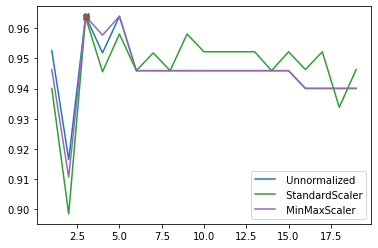

In [29]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    plt.plot(results[params], results['mean_test_score'], label=prefix)

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx],marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV sensitivity:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test sensitivity:", recall_score(y_test, cv.best_estimator_.predict(X_test)))
    
# Plot the cv lines
show_results(cv, X_test, "param_n_neighbors", prefix="Unnormalized")
show_results(cv_std, X_test, 'param_knn__n_neighbors', "StandardScaler")
show_results(cv_minmax, X_test, 'param_knn__n_neighbors', "MinMaxScaler")

The obtained results show that the KNN model is able to perform in the same way, both considering the cross validation sensitivity and the test sensitivity, independently on the fact that the features have been normalized using the range normalization or they are unnormalized. On the other hand the performance of KNN is lower if trained on standard normalized features. Both in case of unnormalized features, with range normalized ones and with standard normalization the best performance is achived looking at the 3 closest training points.

Being the best parameter k=3 means that the corresponding decision boundary is quite complex and not linear: this agrees with the results obtained until now.

The fact that the performance of KNN is the same in case of normalized and unnormalized features, or even lower in the first case, is due to the fact that all the features are already in the same range between 1-10 and so the scaling of the variables is not useful.

## Model evaluation

Train accuracy: 0.9874476987447699
Test accuracy: 0.9560975609756097
Sensitivity 0.9444444444444444
Specificity 0.9624060150375939
Precision  0.9315068493150684
F1-score 0.9379310344827586
AUC train: 0.9993934959662668
AUC test: 0.964703425229741



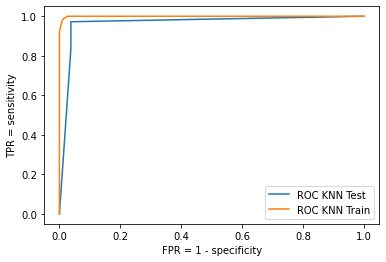

In [30]:
model = KNeighborsClassifier(3)
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

cm = confusion_matrix(y_test, model.predict(X_test))
print("Sensitivity", sensitivity(cm))
print("Specificity", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm))
print(f'AUC train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}')
print(f'AUC test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}\n')

plot_roc(model.predict_proba, X_test, y_test, "KNN Test")
plot_roc(model.predict_proba, X_train, y_train, "KNN Train")

# Classification with Support Vector Machine

SVM classifier is the most robust algorithm meaning that the decision line is the farthest away from the training points that are the closest to it: this ensures that the algorithm is actually good in classifying whatever new data even in the case there is noise inside it.  

The function to minimize in order to get the SVM boundary line is:
$\quad \min _{\mathbf{w}, w_{0}, \xi}\left\{\frac{1}{2}\|\mathbf{w}\|^{2}+\dfrac{1}{C} \sum_{i=1}^{N} \xi_{i}\right\}$

The slack variable 𝜉𝑖 is the price paid each time a missclassification is done by the model (the slack variable has 0 value for correctly classified points, if a point is missclassified but within the margin it has a value major than 1 while a missclassified point above the margin has a slack value minor than 1). The lower the C parameter, the more important the slack variable is in the optimization function and so the more relaxed the margins are (and the larger the number of support vectors). The higher the C, the less important the slack variable is. 
In case we don't want any error we set C as infinite so that the slack variable doesn't count anymore: in this case we obtain very hard margins.

The tooning of the C parameter is connected directly with the bias-variance trade-off: if C is high we force the boundary to be stick to the data (so high variance and low bias); if C is low we allow less strict boundary (so lower variance but higher bias).
Grid search with cross validation can be used to find the best C parameter.

In [31]:
# We start training a linear SVM classifier
from sklearn.svm import SVC

# Define the set of C parameters to test
param_grid = {'C': np.linspace(0.001, 100, 5)}
# Build the linear SVM classifier
svm_linear = GridSearchCV(SVC(kernel='linear'), param_grid,
                        cv=5, scoring='recall', refit=True)
svm_linear.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='recall')

In [32]:
from sklearn.metrics import accuracy_score

cv_score = svm_linear.best_score_
svm_linear = svm_linear.best_estimator_
print(svm_linear)
    
train_rec = recall_score(y_train, svm_linear.predict(X_train))
test_rec = recall_score(y_test, svm_linear.predict(X_test))
print("cv score: {}".format(cv_score))
print("train score: {}".format(train_rec))
print("test score: {}".format(test_rec))

SVC(C=25.00075, kernel='linear')
cv score: 0.9582887700534759
train score: 0.9700598802395209
test score: 0.9583333333333334


From the Grid Search analysis the linear SVM model with the best cross validation sensitivity score is the one with the C parameter equal to 25.

## Kernel Trick with SVM

Since the observations of different classes are not always seperable in a linear way, and from the results obtained untill now this is very probable our case, the Kernel Trick consists of firstly applying a transformation on the features and then find the SVM boundary: consequently the boundary is linear in the new feature space but not linear in the original input feature space.

There are different Kernel transformations that can be applied: to find the best one Grid search method with cross validation is used.

In [33]:
from sklearn.model_selection import GridSearchCV

# use three different kernels (poly, rbf, sigmoid)

# Polynomial
param_grid = {'C': np.linspace(0.001, 10, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='recall', refit=True)
svm_poly.fit(X_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='recall', refit=True)
rbf_poly.fit(X_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='recall', refit=True)
sigm_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='recall')

In [34]:
for m in [svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    
    train_rec = recall_score(y_train, m.predict(X_train))
    test_rec = recall_score(y_test, m.predict(X_test))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_rec))
    print("test score: {}\n".format(test_rec))

SVC(C=0.001, coef0=-10.0, kernel='poly')
cv score: 0.9582887700534759
train score: 0.9461077844311377
test score: 0.9583333333333334

SVC(C=25.00075, gamma=0.001)
cv score: 0.9581105169340465
train score: 0.9700598802395209
test score: 0.9583333333333334

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score: 0.9581105169340465
train score: 0.9640718562874252
test score: 0.9583333333333334



We can see that all the kernels - linear, polynomial, RBF and Sigmoid - have the same performance looking at the cross validation sensitivity and the test sensitivity.

Thus, I decided to repeat the same analysis using as evaluation score the accuracy to understand which kernel is the best one.

In [35]:
from sklearn.model_selection import GridSearchCV

# use three different kernels (poly, rbf, sigmoid)

# Polynomial
param_grid = {'C': np.linspace(0.001, 10, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
svm_poly = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='accuracy', refit=True)
svm_poly.fit(X_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='accuracy', refit=True)
rbf_poly.fit(X_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='accuracy', refit=True)
sigm_poly.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='accuracy')

In [36]:
for m in [svm_poly, rbf_poly, sigm_poly]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    
    train_acc = accuracy_score(y_train, m.predict(X_train))
    test_acc = accuracy_score(y_test, m.predict(X_test))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_acc))
    print("test score: {}\n".format(test_acc))

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
cv score: 0.9728070175438596
train score: 0.9790794979079498
test score: 0.9560975609756097

SVC(C=25.00075, gamma=0.001)
cv score: 0.9728070175438596
train score: 0.9811715481171548
test score: 0.9609756097560975

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score: 0.9728070175438596
train score: 0.9769874476987448
test score: 0.9609756097560975



RBF and Sigmoid kernel have the same performance looking at the cross validation and test accuracy. Furthermore, both of them performs the best with C=25.

## Logistic Regressor and Perceptron vs SVM classifier - Robustness

Comparison between three linear algorithms that produce a linear boundary: SVM, Logistic Regression and the Perceptron (usually less reliable than SVM).

In [37]:
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Train the SVM
svm_model = SVC(kernel='linear',C=25)
svm_model.fit(X_train, y_train)

# Train a LogisticRegressor
lr_model = LogisticRegression(fit_intercept=True, solver='lbfgs')
lr_model.fit(X_train, y_train)

# Train a Perceptron classifier 
pt_model = Perceptron()
pt_model.fit(X_train, y_train)

for m in [svm_model, lr_model, pt_model]:
    train_rec = recall_score(y_train, m.predict(X_train))
    test_rec = recall_score(y_test, m.predict(X_test))
    print("{} train score: {}".format(m.__class__.__name__, train_rec))
    print("{} test score: {}".format(m.__class__.__name__, test_rec))

SVC train score: 0.9700598802395209
SVC test score: 0.9583333333333334
LogisticRegression train score: 0.9640718562874252
LogisticRegression test score: 0.9444444444444444
Perceptron train score: 0.9640718562874252
Perceptron test score: 0.9305555555555556


Perceptron is the model with the lowest test sensitivity: this suggests that the problem is not linearly separable.
The best linear classifier according with test sensitivity is Support Vector Machine, while the Logistic Regressor has a performance that is between the one of Perceptron and SVM.

## Model evaluation

Since we previously saw that RBS and Sigmoid kernel are the ones for which the SVM classifier performs the best according to cross validation and test accuracy, I decided to look at all the possible evaluation metrics to understand which kernel is actually the best.

Train accuracy Sigmoid kernel: 0.9811715481171548
Test accuracy Sigmoid kernel: 0.9609756097560975
Sensitivity  0.9583333333333334
Specificity  0.9624060150375939
Precision  0.9324324324324325
F1-score 0.9452054794520548
AUC test: 0.9916457811194652



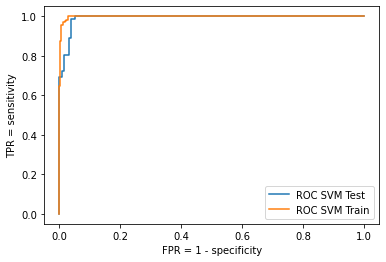

In [38]:
svm_model = SVC(kernel='rbf', C=25, gamma=0.001, probability=True)
svm_model = svm_model.fit(X_train, y_train)

print("Train accuracy Sigmoid kernel:", accuracy(y_train, svm_model.predict(X_train)))
print("Test accuracy Sigmoid kernel:", accuracy(y_test, svm_model.predict(X_test)))

cm = confusion_matrix(y_test,svm_model.predict(X_test))

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm))
print(f'AUC test: {roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])}\n')

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()
    
plot_roc(svm_model.predict_proba, X_test, y_test, "SVM Test")
plot_roc(svm_model.predict_proba, X_train, y_train, "SVM Train")

Train accuracy Sigmoid kernel: 0.9769874476987448
Test accuracy Sigmoid kernel: 0.9609756097560975
Sensitivity  0.9583333333333334
Specificity  0.9624060150375939
Precision  0.9324324324324325
F1-score 0.9452054794520548
AUC test: 0.9926900584795322



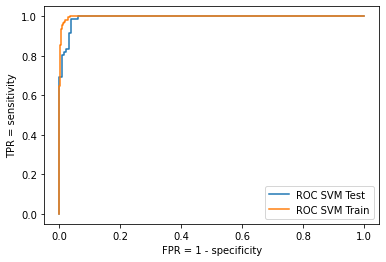

In [39]:
svm_model = SVC(kernel='sigmoid', C=25, gamma=0.001, probability=True)
svm_model = svm_model.fit(X_train, y_train)

print("Train accuracy Sigmoid kernel:", accuracy(y_train, svm_model.predict(X_train)))
print("Test accuracy Sigmoid kernel:", accuracy(y_test, svm_model.predict(X_test)))

cm = confusion_matrix(y_test,svm_model.predict(X_test))

print("Sensitivity ", sensitivity(cm))
print("Specificity ", specificity(cm))
print("Precision ", precision(cm))
print("F1-score", f1(cm))
print(f'AUC test: {roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])}\n')

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()
    
plot_roc(svm_model.predict_proba, X_test, y_test, "SVM Test")
plot_roc(svm_model.predict_proba, X_train, y_train, "SVM Train")

The two SVM models trained using data transformed applying RBF and Sigmoid kernels perform exactly the same looking at all the possible metrics but one: the area under the ROC curve of the SVM classifier with Sigmoid kernel is slightly higher. 
Anyway I can conclude that the two kernels perform in equivalent way.

# Comparison between all the classification models

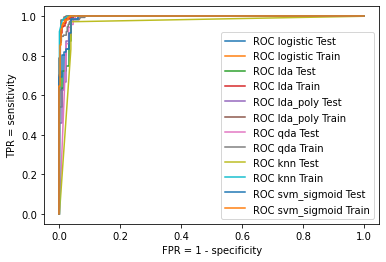

In [40]:
from sklearn.model_selection import cross_val_score

logistic = LogisticRegression(solver="newton-cg", penalty='none')  
lda = LDA()
lda_poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                     ('lda', LDA(store_covariance=True))])
qda = QDA()
knn = KNeighborsClassifier(n_neighbors=3)
svm_model = SVC(kernel='sigmoid', C=25, gamma=0.001, probability=True)

from collections import OrderedDict
models = OrderedDict([('logistic', logistic), ('lda', lda), ('lda_poly', lda_poly), ('qda', qda),
                      ('knn', knn), ('svm_sigmoid', svm_model)])
    
cv_scores, test_scores, sensitivity_scores, f1_scores, AUC_scores = [], [], [], [], []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring = make_scorer(recall_score))  
    cv_score = np.mean(scores)
    cv_scores.append(cv_score)
    
    model.fit(X_train, y_train) 
    test_score = accuracy(y_test, model.predict(X_test))
    test_scores.append(test_score)
    
    cm = confusion_matrix(y_test, model.predict(X_test))
    s = sensitivity(cm)
    sensitivity_scores.append(s)
    
    f = f1(cm)
    f1_scores.append(f)
    
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    AUC_scores.append(auc)
    
    plot_roc(model.predict_proba, X_test, y_test, f"{name} Test")
    plot_roc(model.predict_proba, X_train, y_train, f"{name} Train")

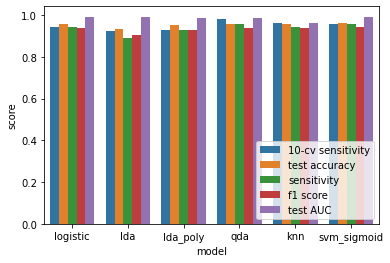

In [41]:
data = pd.DataFrame()
data['model'] = list(models.keys()) * 5
data['metric'] = ['10-cv sensitivity'] * len(cv_scores) + ['test accuracy'] * len(test_scores) + ['sensitivity'] * len(sensitivity_scores) + ['f1 score'] * len(f1_scores) + ['test AUC'] * len(AUC_scores)
data['score'] = cv_scores + test_scores + sensitivity_scores + f1_scores + AUC_scores

sns.barplot(x='model', y='score', data=data, hue='metric')
plt.legend(loc='lower right')

In [42]:
data

,model,metric,score
0,logistic,10-cv sensitivity,0.945956
1,lda,10-cv sensitivity,0.922426
2,lda_poly,10-cv sensitivity,0.928309
3,qda,10-cv sensitivity,0.981618
4,knn,10-cv sensitivity,0.963971
5,svm_sigmoid,10-cv sensitivity,0.957721
6,logistic,test accuracy,0.956098
7,lda,test accuracy,0.936585
8,lda_poly,test accuracy,0.951220
9,qda,test accuracy,0.956098


In [43]:
# best model according to cv sensitivity
data[data['score'] == max(data[data['metric'] == '10-cv sensitivity']['score'])]

,model,metric,score
3,qda,10-cv sensitivity,0.981618


In [44]:
# best model according to test accuracy
data[data['score'] == max(data[data['metric'] == 'test accuracy']['score'])]

,model,metric,score
11,svm_sigmoid,test accuracy,0.960976


In [45]:
# best model according to sensitivity
data[data['score'] == max(data[data['metric'] == 'sensitivity']['score'])]

,model,metric,score
15,qda,sensitivity,0.958333
17,svm_sigmoid,sensitivity,0.958333


In [46]:
# best model according f1 score
data[data['score'] == max(data[data['metric'] == 'f1 score']['score'])]

,model,metric,score
23,svm_sigmoid,f1 score,0.945205


In [47]:
# best model according AUC score
data[data['score'] == max(data[data['metric'] == 'test AUC']['score'])]

,model,metric,score
29,svm_sigmoid,test AUC,0.99269


From this final summary of the performance of all the possible classification models we can clearly see that the classes are not linearly separable since all the linear classifiers - Logistic Regression and linear LDA - show the worst performance. 

The best model according to the sensitivity measured on test set as well as the cross validation sensitivity is QDA.
While SVM with Sigmoid kernel is the best model considering the test accuracy, the f1 score, the test AUC score and also the sensitivity (with the same performance of QDA).

Since what I want to favour is avoiding diagnoising ill people as healthy, the most important score to look at is the sensitivity, since higher is the true positive rate lower is the number of false negatives.
Quadratic Discriminant Analysis and SVM with Sigmoid kernel are the models that ensure the least number of false negatives. For QDA this capability is confirmed also by the sensitivity computed through cross validation.
SVM with Sigmoid kernel at the same time has the highest accuracy computed on new observations, and so on average this is the model that classifies the data in the most correct way, and also it has the highest f1 score meaning it is the most accurate and precise model.

SVM with Sigmoid kernel has a very high AUC on the test set, while QDA is one of the classifiers with the lowest value of this score, althought it is anyway very high.
Consequently, looking at the specificity I expect SVM-Sigmoid to have a higher value of this metric than QDA, considering that they have exactly the same sensitivity but different AUC value.

In conclusion I can say that both the classifiers, QDA and SVM-Sigmoid, work very well since they ensure that the greatest proportion of diseased people are detected. SVM-Sigmoid is the model that makes the lowest number of misclassifications, it has the best sensitivity, a very high AUC score and the highest f1 score, indicating that it is extremely accurate and precise.
However also QDA is very good since the fact it predicts more false positives is somehow the price it has to pay to avoid having lot of false negative predictions: by the end what is mostly important is that the model is able to detect diseased people and this model is as able to do it as well as SVM with Sigmoid kernel.